# Blending Neural Networks with Physics: the Physics Informed Neural Network

In this simple tutorial we will see how to construct a physics informed neural network (PINN), and how we can improve from the base pinn levearging multiple techniques. Let us start by importing `torch` and `matplotlib`

In [1]:
import torch
import matplotlib.pyplot as plt

# the pi value
pi = torch.acos(torch.tensor([-1]))

The basic idea of PINNs is to approximate the differential equation solution with a Neural Network (see figure below). By leveraging Automatic Differentiation we can compute the residuals which can be used as loss functions to evaluate how well the neural network is doing in approximating the solution. The key ingredients for pinns are two: (1) the scattered data of the domain, (2) a neural network approximating the solution.
<div align="center">
<img src="../imgs/pinn.png" width="500"/>
</div>

In this tutorial will solve two equations:
- A simple ODE (for showing the basic PINN for training)
- The Helmotz equation (for showing how to induced PBC in PINNs) 


## Solving ODE with PINNs

The simple ODE which we aim to solve is:
$$
\begin{cases}
\frac{d}{dx}u(x) - u(x) &=  0 \quad x\in(0,1)\\
u(x=0) - 1 &= 0\\
\end{cases}
$$

with the analytical solution $u(x) = e^x$. Suppose to have a neural network depending on some parameters $\theta$ which approximate the solution, let's call it $u_\theta(x)$. Then if we plug the neural network into the above equation, we would obtain a RHS equal to zero only if $u_\theta(x)=u(x)$. That's it! We can use as loss function to train the model:
$$
\mathcal{L} = \|u(x=0) - 1\|^2 + \frac{1}{N}\sum_{i=1}^N\| \frac{d}{dx_i}u(x_i) - u(x_i) \|^2.
$$
This loss function is zero when the network learns the solution. In order to compute the loss we need some scattered data of the domain, and to compute the derivative of the networks with respect to the input. The data can be obtained by sampling the domain $(0, 1)$, e.g. uniform grid. The second one can be obtain by `torch` automatic differentiation! We will now code a PINN from scratch by first:
1. Write a function to compute the first derivative
2. Sampling data in $(0, 1)$
3. Write a simple MLP with layers [10, 10] and hyperbolic tangent activation
4. Train the network and plot the results

In [2]:
# 1.  Write a function to compute the first derivative

def grad(u, x):
    """
    Compute the first derivative of u with respect to x.

    Parameters:
    - u (torch.Tensor): The tensor for which the derivative is calculated (requires_grad=True).
    - x (torch.Tensor): The tensor with respect to which the derivative is calculated.

    Returns:
    - torch.Tensor: The first derivative of u with respect to x.
    """
    # Calculate the gradient
    return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True, retain_graph=True)[0]

Just as small test we compute the $\sin(x)$ derivative with `grad` minus the actual derivative $\cos(x)$. The expected output is a vector of zeros. Importantly, the vector $x$ must have `requires_grad` set to `True` to be able to compute the gradient.

In [3]:
# some samples in [0, pi], setting requires grad to true !!!
x = torch.linspace(0, float(pi), 100, requires_grad=True)
torch.cos(x) - grad(torch.sin(x), x)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<SubBackward0>)

As we can see we obtain a vector of zeros as expected since automatic differentiation is exact! Let us now procede with points (2), (3), and (4). For training we use the Adam optimizer with defualt hyperparameters for $10000$ epochs.

[1000 / 5000] loss 0.009187464602291584
[2000 / 5000] loss 0.0012273532338440418
[3000 / 5000] loss 0.0006998566095717251
[4000 / 5000] loss 0.0004377619188744575
[5000 / 5000] loss 0.00026477192295715213
[6000 / 5000] loss 0.0001359870657324791
[7000 / 5000] loss 4.700007048086263e-05
[8000 / 5000] loss 1.2912729289382696e-05
[9000 / 5000] loss 7.859992365411017e-06
[10000 / 5000] loss 4.902994533040328e-06


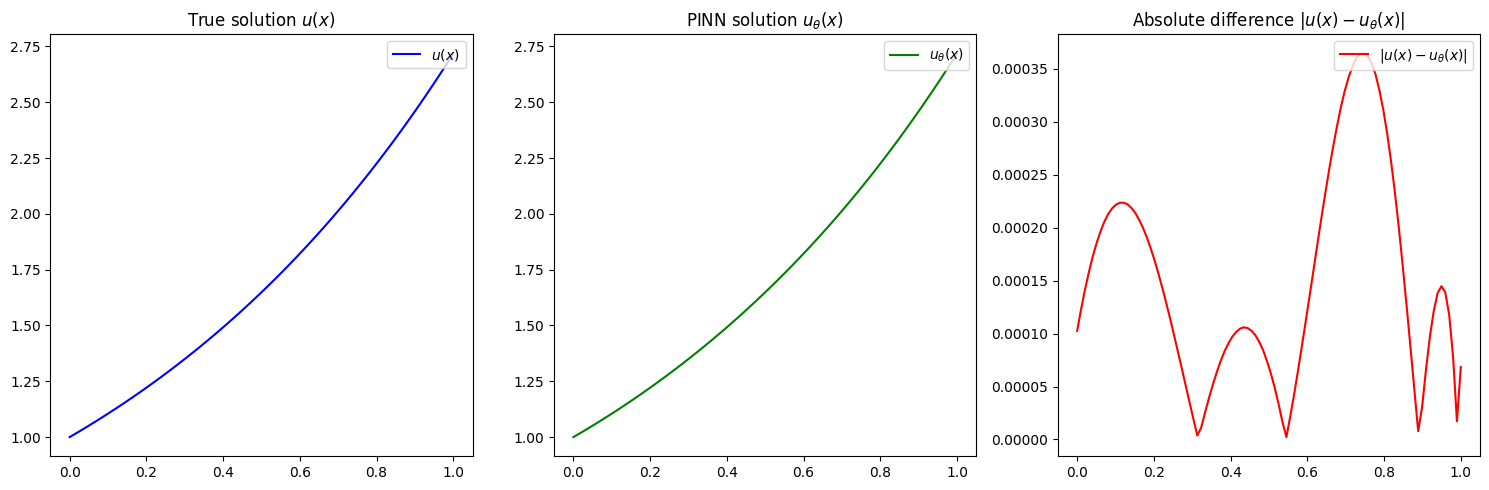

In [4]:
# 2. Sampling data in (0, 1)
x = torch.linspace(1e-6, 1, 100, requires_grad=True).reshape(-1, 1)  # this are point in the interior
x_b = torch.zeros((1, 1))  # this is the initial condition

# 3. Write a simple MLP with layers [10, 10] and hyperbolic tangent activation (the u_theta model)
u_theta = torch.nn.Sequential(torch.nn.Linear(1, 10), torch.nn.Tanh(), torch.nn.Linear(10, 1))

# 4. Train the network and plot the results
optimizer = torch.optim.Adam(u_theta.parameters())
for epochs in range(10000):
    optimizer.zero_grad()
    # evaluate on the boundary
    u_b = u_theta(x_b) 
    # evaluate on the interior + compute the derivative
    u = u_theta(x)
    u_x = grad(u, x)
    # compute loss
    loss = (u_x - u).pow(2).mean() + (u_b - 1).pow(2).mean()
    # optimize
    loss.backward()
    optimizer.step()
    # some statistics
    if (epochs+1) % 1000 == 0:
        print(f'[{epochs+1} / 5000] loss {loss.item()}')

with torch.no_grad():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # Plot 1
    axes[0].plot(x, torch.exp(x), label=r'$u(x)$', color='blue')
    axes[0].set_title(r'True solution $u(x)$')
    axes[0].legend(loc="upper right")
    # Plot 2
    axes[1].plot(x, u_theta(x), label=r'$u_{\theta}(x)$', color='green')
    axes[1].set_title(r'PINN solution $u_{\theta}(x)$')
    axes[1].legend(loc="upper right")
    # Plot 3
    diff = torch.abs(torch.exp(x) - u_theta(x))
    axes[2].plot(x, diff, label=r'$|u(x) - u_{\theta}(x)|$', color='red')
    axes[2].set_title(r'Absolute difference $|u(x) - u_{\theta}(x)|$')
    axes[2].legend(loc="upper right")
    # Adjust layout
    plt.tight_layout()
    # Show the plots
    plt.show()

Great, we built from scratch a Physics Informed Neural Network! Although the considered ODE is very simple, the base procedure of training the PINN is applicable for more complex ODEs or PDEs! 

## The Helmotz equation

What happens if I have an ODE of this form:
$$
\begin{cases}
\frac{d^2}{dx^2}u(x) - \lambda u(x) -f(x) &=  0 \quad x\in(0,2)\\
u^{(m)}(x=0) - u^{(m)}(x=2) &= 0 \quad m\in[0, 1, \cdots]\\
\end{cases}
$$
In this case we are asking the solution to be $C^{\infty}$ periodic with period $2$, on the inifite domain $x\in(-\infty, \infty)$. Obviusly we can not rewrite the loss function as before, since we would need infinite terms for the boundaries...

A possible solution, diverging from the original PINN formulation, is to use *coordinates augmentation*. In coordinates augmentation you seek for a coordinates transformation $\Phi$ such that $x\rightarrow\Phi(x)$ such that the condition $ u^{(m)}(x=0) - u^{(m)}(x=2) = 0 \quad m\in[0, 1, \cdots] $ is satisfied. It turns out (see [2]) that this can be easily achieved by writing $\Phi(x) = [\cos(\pi x), \sin(\pi x)]$.

We will not go into the details on why this formulation is correct, but this enable us not to compute the derivative and only check for $m=0$! If you are interested in coordinates augmentation consider this readings for starting:
1. *Wang, Sifan, Hanwen Wang, and Paris Perdikaris. "On the eigenvector bias of Fourier feature networks: From regression to solving multi-scale PDEs with physics-informed neural networks." Computer Methods in Applied Mechanics and Engineering 384 (2021): 113938.*
2. *Dong, Suchuan, and Naxian Ni. "A method for representing periodic functions and enforcing exactly periodic boundary conditions with deep neural networks." Journal of Computational Physics 435 (2021): 110242.*
3. *Demo, Nicola, Maria Strazzullo, and Gianluigi Rozza. "An extended physics informed neural network for preliminary analysis of parametric optimal control problems." Computers & Mathematics with Applications 143 (2023): 383-396.*


We will solve the problem as before, but we will add a `torch` layer for computing the map $\Phi$. For demonstration porpuses the problem specifics are $\lambda=-10\pi^2$, and $f(x)=-6\pi^2\sin(\pi x)\cos(3\pi x)$ which gives a solution that can be computed analytically $u(x) = \sin(\pi x)\cos(3\pi x)$.


[1000 / 10000] loss 278.0238037109375
[2000 / 10000] loss 64.64591217041016
[3000 / 10000] loss 3.661750555038452
[4000 / 10000] loss 1.536690354347229
[5000 / 10000] loss 0.5400407910346985
[6000 / 10000] loss 0.15155595541000366
[7000 / 10000] loss 0.08313937485218048
[8000 / 10000] loss 0.0716608539223671
[9000 / 10000] loss 0.06403625756502151
[10000 / 10000] loss 0.07086550444364548


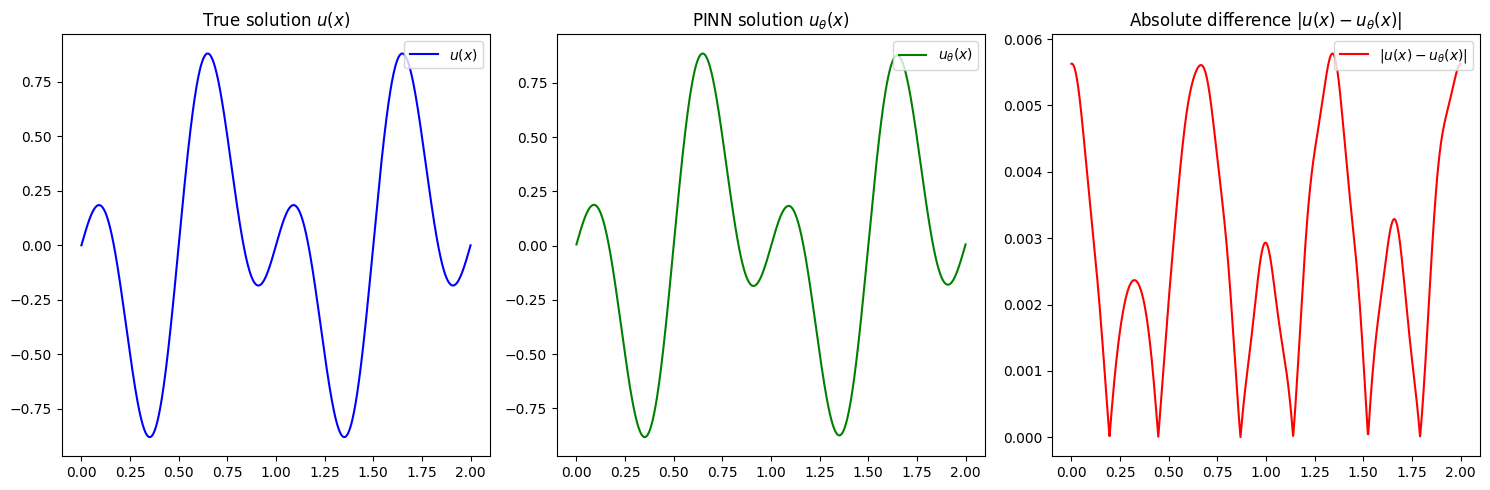

In [22]:
# 1. Build the torch Phi layer
class Phi(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.cat([torch.ones_like(x), torch.cos(pi * x), torch.sin(pi * x)], dim=-1)

# 2. Sampling data in (0, 2)
x = torch.linspace(1e-6, 2, 100, requires_grad=True).reshape(-1, 1)  # this are point in the interior
x_b1 = torch.zeros((1, 1))  # this is the initial condition
x_b2 = torch.zeros((1, 1)) + 2  # this is the initial condition

# 3. Write a simple MLP with layers [10, 10] and hyperbolic tangent activation (the u_theta model) + Phi block !
u_theta = torch.nn.Sequential(Phi(), torch.nn.Linear(3, 10), torch.nn.Tanh(), torch.nn.Linear(10, 1))

# 4. Train the network and plot the results
optimizer = torch.optim.Adam(u_theta.parameters())
for epochs in range(10000):
    optimizer.zero_grad()
    # evaluate on the interior + compute the derivative
    u = u_theta(x)
    u_x = grad(u, x)
    u_xx = grad(u_x, x)
    # compute loss
    loss = (u_xx + 10 * (pi**2) * u + 6 * (pi**2) * torch.sin(3 * pi * x)*torch.cos(pi*x)).pow(2).mean()
    # optimize
    loss.backward()
    optimizer.step()
    # some statistics
    if (epochs+1) % 1000 == 0:
        print(f'[{epochs+1} / 10000] loss {loss.item()}')

with torch.no_grad():
    x = torch.linspace(0, 2, 1000).reshape(-1, 1)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # Plot 1
    axes[0].plot(x, torch.sin(pi * x)*torch.cos(3*pi*x), label=r'$u(x)$', color='blue')
    axes[0].set_title(r'True solution $u(x)$')
    axes[0].legend(loc="upper right")
    # Plot 2
    axes[1].plot(x, u_theta(x), label=r'$u_{\theta}(x)$', color='green')
    axes[1].set_title(r'PINN solution $u_{\theta}(x)$')
    axes[1].legend(loc="upper right")
    # Plot 3
    diff = torch.abs(torch.sin(pi * x)*torch.cos(3*pi*x) - u_theta(x))
    axes[2].plot(x, diff, label=r'$|u(x) - u_{\theta}(x)|$', color='red')
    axes[2].set_title(r'Absolute difference $|u(x) - u_{\theta}(x)|$')
    axes[2].legend(loc="upper right")
    # Adjust layout
    plt.tight_layout()
    # Show the plots
    plt.show()

Great! This seeams a good result, considering the simple neural network used to some this (complex) problem. We will now test the neural network on the domain $[-4, 4]$ without retraining. In principle the periodicity should be present since the $\Phi$ function ensures the periodicity in $(-\infty, \infty)$.

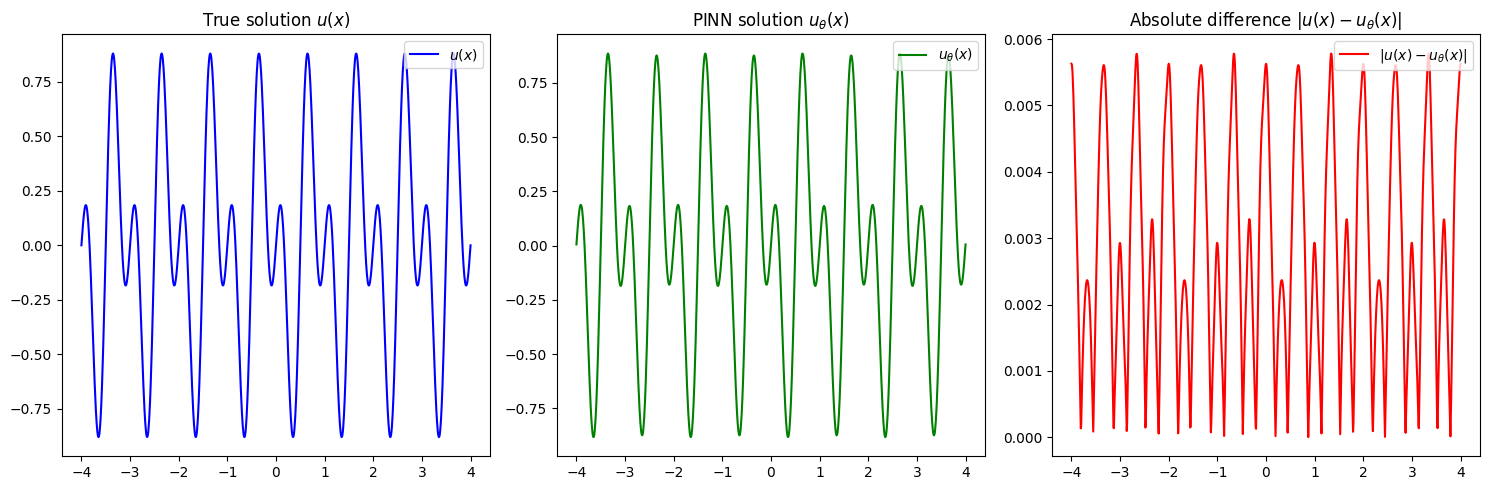

In [23]:
with torch.no_grad():
    # Notice here we put [-4, 4]!!!
    x = torch.linspace(-4, 4, 1000).reshape(-1, 1)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # Plot 1
    axes[0].plot(x, torch.sin(pi * x)*torch.cos(3*pi*x), label=r'$u(x)$', color='blue')
    axes[0].set_title(r'True solution $u(x)$')
    axes[0].legend(loc="upper right")
    # Plot 2
    axes[1].plot(x, u_theta(x), label=r'$u_{\theta}(x)$', color='green')
    axes[1].set_title(r'PINN solution $u_{\theta}(x)$')
    axes[1].legend(loc="upper right")
    # Plot 3
    diff = torch.abs(torch.sin(pi * x)*torch.cos(3*pi*x) - u_theta(x))
    axes[2].plot(x, diff, label=r'$|u(x) - u_{\theta}(x)|$', color='red')
    axes[2].set_title(r'Absolute difference $|u(x) - u_{\theta}(x)|$')
    axes[2].legend(loc="upper right")
    # Adjust layout
    plt.tight_layout()
    # Show the plots
    plt.show()

It is pretty clear that the network is periodic, with also the error following a periodic pattern. Obviusly a longer training, and a more expressive neural network could easy the training!